# Interpreting Hyperspectral Images with LIME: HYPERVIEW Challenge

This notebook demonstrates the usability of the Local Interpretable Model-agnostic Explanations (LIME) algorithm to interpret the predictions of a hyperspectral image regression model. The dataset used in this notebook is from the [HYPERVIEW Challenge](https://ai4eo.eu/challenge/hyperview-challenge/) organized by The European Space Agency (ESA). The goal of the challenge is to predict `4` soil parameters based on the hyperspectral images of the ground.

The model used in this notebook is one of the top-performing models in the challenge. The trained model architecture is based on the Vision Transformer (ViT) and CLIP (Contrastive Language-Image Pretraining), and its fine-tuned weights are open-sourced under the Apache License in the [Hugging Face Model Hub](https://huggingface.co/KPLabs/HYPERVIEW-VisionTransformer). In the same place the original implementation of the CLIP model can be found. 

**Note**: Before running this notebook, make sure to install the required libraries used in the notebook. It should be sufficient to install the package `meteors` from PyPI, as it carry all the required dependencies, but in some cases, you might need to install additional ones. The `clip_model` module contains the code needed for additional preprocessing and model loading and can be downloaded from the [Vignettes in the `meteors` repository](https://github.com/xai4space/meteors/tree/main/examples/lime)



## Table of Contents
- [1. Loading the Model](#1-loading-the-model)
- [2. Loading the Hyperspectral data from HYPERVIEW Challenge](#2-load-the-hyperspectral-data-from-hyperview-challenge)
- [3. Convert data into HSI image and preview the images](#3-convert-data-into-hsi-image-and-preview-the-images)
- [4. Analyze HSI data with LIME](#4-analyze-hsi-data-with-lime)
  - [4.1. Spatial Analysis](#41-spatial-analysis)
  - [4.2. Spectral Analysis](#42-spectral-analysis)

In [1]:
import os
import torch
import urllib
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

import meteors as mt

from clip_utils import load_base_clip, download

# Always try to set the seed for repeatability :)
torch.manual_seed(0)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## 1. Loading the Model

The dataset used for training this model can be found on the official page for the [HYPERVIEW Challenge](https://ai4eo.eu/challenge/hyperview-challenge/).

The following code loads pre-trained CLIP weights and fine-tuned weights for the model.

In [3]:
download_root = os.path.expanduser("~/.cache/clip")
num_classes = 4

Load the CLIP model with the HYPERVIEW head

In [4]:
model = load_base_clip(download_root=download_root, class_num=num_classes)

Load the pre-trained weights

In [5]:
vit_checkpoint_path = download(
    "https://huggingface.co/KPLabs/HYPERVIEW-VisionTransformer/resolve/main/VisionTransformer.pt",
    download_root,
    error_checksum=False,
)
model.load_state_dict(torch.load(vit_checkpoint_path, map_location=device))
model.eval()
model = model.to(device)

## 2. Load the Hyperspectral data from HYPERVIEW Challenge

In this notebook, we will use the sample images from the HYPERVIEW Challenge dataset. The images are stored in the [vignettes folder for the lime example](https://github.com/xai4space/meteors/tree/main/examples/hyperview_challenge) in the `data` folder. The images are in the `.npy` format. The images are 3D hyperspectral images with 150 bands and various spatial dimensions. The images are stored in the raw format and contain both the hyperspectral image and the mask applied while training the model.

First, we need to define the loading and preprocessing functions for the data.

In [6]:
def _shape_pad(data):
    max_edge = np.max(data.shape[1:])
    shape = (max_edge, max_edge)
    padded = np.pad(
        data,
        ((0, 0), (0, (shape[0] - data.shape[1])), (0, (shape[1] - data.shape[2]))),
        "constant",
        constant_values=0.0,
    )
    return padded


def load_single_npz_image(image_path):
    with np.load(image_path) as npz:
        data = npz["data"]
        mask = npz["mask"]

        mask = 1 - mask.astype(int)

        mask = _shape_pad(mask)
        data = _shape_pad(data)

        mask = mask.transpose((1, 2, 0))
        data = data.transpose((1, 2, 0))
        data = data / 5419

        return data, mask


def get_eval_transform(image_shape):
    return transforms.Compose(
        [
            transforms.Resize((image_shape, image_shape)),
        ]
    )

Now, let's load the hyperspectral image using functions we defined earlier.

In [7]:
data, mask = load_single_npz_image("data/0.npz")
masked_data = data * mask
masked_data = torch.from_numpy(masked_data.astype(np.float32)).permute(2, 0, 1)
eval_tr = get_eval_transform(224)

image_torch = eval_tr(masked_data)
not_masked_image_torch = eval_tr(torch.from_numpy(data.astype(np.float32)).permute(2, 0, 1))

print(f"Original data shape: {data.shape}")
print(f"Original mask shape: {mask.shape}")
print(f"Transformed data shape: {image_torch.shape}")

Original data shape: (89, 89, 150)
Original mask shape: (89, 89, 150)
Transformed data shape: torch.Size([150, 224, 224])


As we can see, the image is a 3D NumPy array with a shape transformed to (150, 224, 224), where 150 is the number of bands and 224x224 is the spatial dimension of the image. We will keep the image in both masked and unmasked formats.

Now, we need to specify the wavelengths of the bands in the image. The wavelengths were provided in the challenge dataset, but to avoid loading additional files, we save it as a simple pythonic list.

In [8]:
with open("data/wavelenghts.txt", "r") as f:
    wavelengths = f.readline()
wavelengths = [float(wave.strip()) for wave in wavelengths.split(",")]

## 3. Convert Data into HSI Image and Preview the Images
Now, having the raw data - the tensor representing the image, its wavelengths and the image orientation, we can to combine this information into a complete hyperspectral image. To create the hyperspectral image, we will use the `HSI` data class from the `meteors` package.

The `HSI` (HyperSpectral Image) class takes the hyperspectral image data, the wavelength data, and the orientation of the image as input and creates the meaningful hyperspectral image, that can be easily analysed in any downstream task.

Additionally, we may provide the binary mask, which may cover data irrelevant for the task, as suggested by the challenge dataset providers. In our case we cover the regions where there is land whose parameters we do not want to estimate, for instance some forests, roads or rivers. If we learned the model on such unmasked data, it could falsely underestimate the predictions, since the measured soil parameters in such uncultivated land is usually lower. We create a binary mask from the image, where 1 is the masked region and 0 is the unmasked region.

In [9]:
binary_mask = (image_torch > 0.0).int()

The HSI object attributes:

- `data`: Preprocessed hyperspectral image data (numpy/pytorch array, shape: bands × height × width)
- `wavelengths`: List of hyperspectral image wavelengths
- `orientation`: Image orientation, e.g. `CWH` (Channels × Width × Height)
- `binary_mask`: Binary mask for the image
- `device`: Storage device for image data (can be set later via `.to(device)`)

In [10]:
hsi_0 = mt.HSI(
    image=not_masked_image_torch,
    wavelengths=wavelengths,
    orientation="CWH",
    binary_mask=binary_mask,
    device=device,
)

Now, let's view the hyperspectral image along with the masked and unmasked versions.

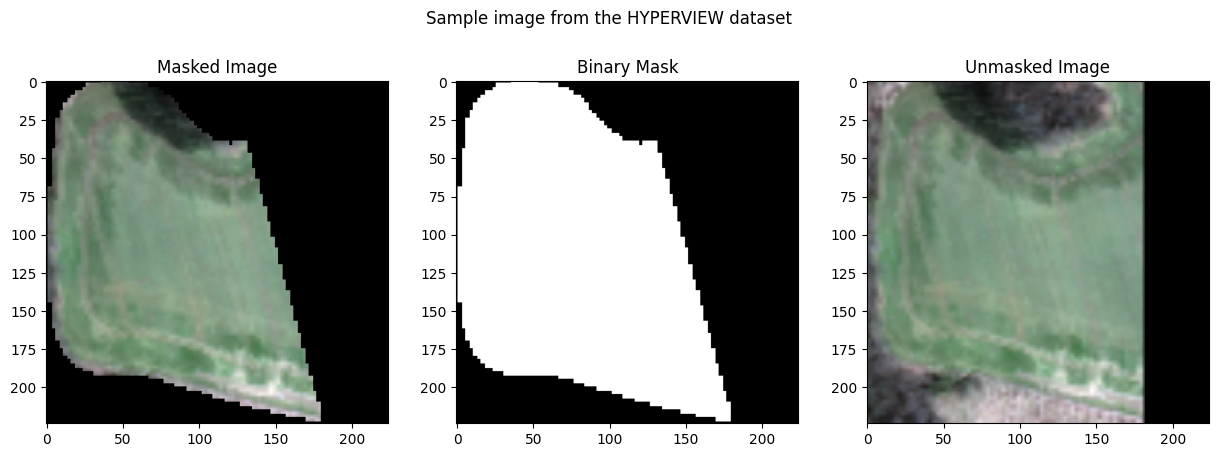

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

mt.visualize.visualize_hsi(hsi_0, ax1, use_mask=True)
ax1.set_title("Masked Image")

ax2.imshow(binary_mask[0, ...].T.cpu().numpy(), cmap="gray")
ax2.set_title("Binary Mask")

mt.visualize.visualize_hsi(hsi_0, ax3, use_mask=False)
ax3.set_title("Unmasked Image")

fig.suptitle("Sample image from the HYPERVIEW dataset")
plt.show()

The `HSI` dataclass streamlines hyperspectral image processing by automatically generating clean RGB visualizations from the complex hyperspectral data. This automation eliminates common manual tasks like wavelength band selection and image orientation correction. The dataclass handles the conversion from high-dimensional spectral data to a standard RGB representation, making it easier to visually inspect and validate the hyperspectral imagery before analysis.

For model prediction, we can directly input the processed hyperspectral image into our classifier. The model performs multi-class classification across 4 distinct classes.


In [12]:
original_prediction = model(not_masked_image_torch.unsqueeze(0))
hsi_prediction = model(hsi_0.image.unsqueeze(0))
assert torch.allclose(original_prediction, hsi_prediction, atol=1e-3)

The classes of the HYPERVIEW dataset

In [13]:
prediction_dict = {0: "Phosphorus", 1: "Potassium", 2: "Magnesium", 3: "pH"}

In [14]:
predictions = {prediction_dict[i]: float(hsi_prediction[0, i].cpu().detach().numpy()) for i in range(4)}
predictions = pd.Series(predictions)
predictions

Phosphorus    0.210551
Potassium     0.350670
Magnesium     0.391935
pH            0.883228
dtype: float64

## 4. Analyze HSI Data with LIME
[LIME](https://dl.acm.org/doi/abs/10.1145/2939672.2939778) (Local Interpretable Model-agnostic Explanations) is a model-agnostic algorithm that explains the predictions of a model by approximating the model's decision boundary around the prediction. It transforms the local area of the sample into interpretable space by creating superbands or superpixels which are the blocks that make up the sample. The algorithm generates a set of perturbed samples around the input sample and fits a linear model to the predictions of the perturbed samples. The linear model is then used to explain the prediction of the input sample.

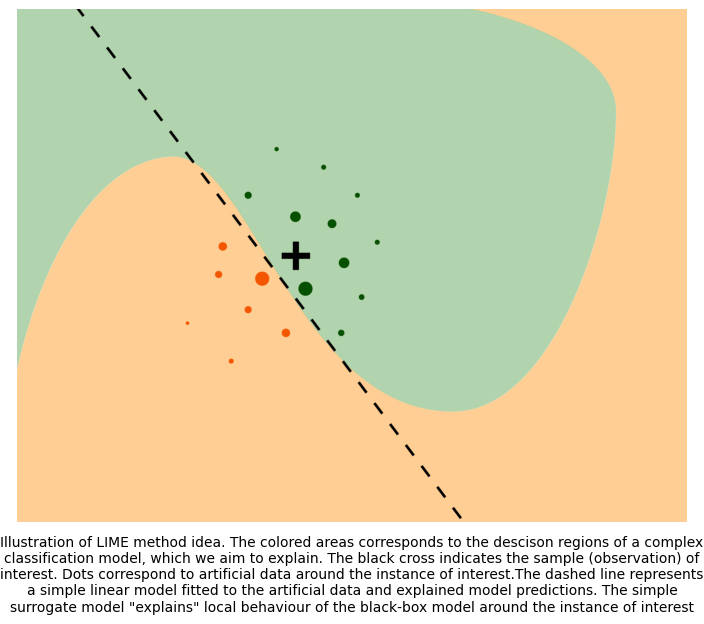

In [15]:
img = Image.open(urllib.request.urlopen("https://ema.drwhy.ai/figure/lime_introduction.png"))
fig, ax = plt.subplots(figsize=(7, 7))

ax.imshow(img)
ax.axis("off")

plt.figtext(
    0.5,
    0.01,
    'Illustration of LIME method idea. The colored areas corresponds to the descison regions of a complex classification model, which we aim to explain. The black cross indicates the sample (observation) of interest. Dots correspond to artificial data around the instance of interest.The dashed line represents a simple linear model fitted to the artificial data and explained model predictions. The simple surrogate model "explains" local behaviour of the black-box model around the instance of interest',
    wrap=True,
    horizontalalignment="center",
)

plt.tight_layout()
plt.show()

An image above with explanation of LIME idea is taken from the *Explanatory Model Analysis* book, by Przemyslaw Biecek and Tomasz Burzykowski (2021).

To initialize the LIME object, we need to provide the following parameters:

- `explainable_model`: The model to be explained, used to predict the hyperspectral image and the task type. In order to integrate any model with our methods, the model has to be wrapped in a class from the meteors package, providing additional info for the LIME explainer, such as the problem type
- `interpretable_model`: The model used to approximate the decision boundary of the model. It could be any kind of easily interpretable model. The package provides implementations of Ridge and Lasso linear models ported from `sklearn` library and in this notebook we use a Lasso regression model

Meteors package supports explaining the model solving 3 different machine learning problems:

- Regression
- Classification
- Segmentation

Since the linear, interpretable models used in the package for creating the LIME explanations do not solve directly the segmentation problem, we apply a handy trick that converts this problem into a regression problem that can be solved by linear models. This idea is inspired from the `captum` library and involves appropriately counting pixels in the segmentation mask so that the number of pixels in each segment can be estimated by the regression model.

First, lets wrap the model in the meteors model wrapper

In [16]:
explainable_model = mt.models.ExplainableModel(model, "regression")

next create the interpretable model with regularization strength of 0.001

In [17]:
interpretable_model = mt.models.SkLearnLasso(alpha=0.001)

Let's initialize the LIME explainer with the CLIP model!

In [18]:
lime = mt.attr.Lime(explainable_model, interpretable_model)

## 4. Analyze HSI data with LIME
Our implementation of LIME explainer enables to analyze HSI data based on the spatial or spectral dimension. It allows to investigate which regions or which spectral bands are the most relevant for the model. The rest of the notebook will be divided into spectral and spatial analysis of HSI data.

### 4.1. Spatial Analysis
Similar to the original implementation of LIME for images, we will create spatial superpixels which are perturbed and used to train a surrogate model for explaining. These explanations will produce a correlation map with the output for each superpixel.
Firstly, to generate attributions, we need to prepare the segmentation mask. Essentially, the segmentation mask is a torch tensor or numpy ndarray that contains information to which superpixel (region) does the specified pixel belongs. Integer values in such tensor represent the labels of superpixels. The mask should have the same shape as the image, but should be repeated along the channels dimension. The package now supports three methods to create the mask:

- Using [SLIC](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_segmentations.html) for superpixel detection
- Using patch segmentation. Knowing that ViT uses squared non-overlapping sliding windows, we can also make superpixels based on the same technique
- Providing a custom mask

In this notebook we will present, how can we utilize different segmentation masks to investigate the model's performance and explore interesting areas in the images

In [19]:
segmentation_mask_slic = lime.get_segmentation_mask(hsi_0, segmentation_method="slic")
segmentation_mask_patch = lime.get_segmentation_mask(hsi_0, segmentation_method="patch", patch_size=14)

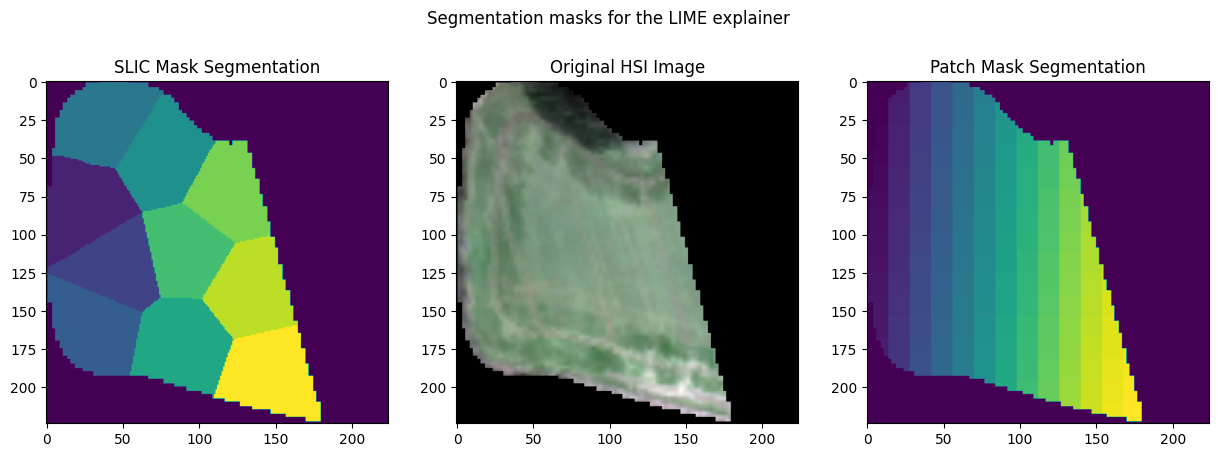

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.imshow(segmentation_mask_slic[0, ...].T)
ax1.set_title("SLIC Mask Segmentation")

mt.visualize.visualize_hsi(hsi_0, ax2, use_mask=True)
ax2.set_title("Original HSI Image")

ax3.imshow(segmentation_mask_patch[0, ...].T)
ax3.set_title("Patch Mask Segmentation")

fig.suptitle("Segmentation masks for the LIME explainer")

plt.show()

Now, since we have our HSI sample data, segmentation mask and LIME model prepared, we will produce attribution maps for the segments. To do this, we simply need to execute one method `get_spatial_attributes`, and provide the HSI data, segmentation mask, and target class to be analyzed. If our model predicts more than one class (the model's output is multidimensional), we need to specify which target class we want to analyze. For each class, the analysis of the correlation with segments can be different.

In [21]:
spatial_attributes = lime.get_spatial_attributes(
    hsi_0,
    segmentation_mask_slic,
    target=1,
    n_samples=10,
    perturbations_per_eval=4,
)

method `get_spatial_attributes` apart from the 3 required fields:

- `hsi` - the hyperspectral image data
- `mask` - the segmentation mask
- `target` - the target index class to be analyzed: K - potassium - 1

takes as well few optional hyperparameters of explanations. Those are:

- `n_samples` - it is a number of the generated artificial samples on which the linear model is trained. The larger number of samples, the explanations produced by the linear model are usually better, since its predictions should better mimic the predictions of the explained model. However, the larger `n_samples` the longer attribution takes to be performed
- `perturbations_per_eval` - an inner batch size, this parameter may fasten the attribution, depending your machine capacity
- `verbose` - a parameter specifying whether to output a progress bar, that makes the waiting time for attribution more pleasant

The method has also an option to generate the segmentaion mask by itself, utilizing the static method `get_segmentation_mask` method under the hood.

More information about the `get_spatial_attributes` function can be found in its [reference page](https://xai4space.github.io/meteors/latest/reference/#src.meteors.attr.lime.Lime) on the documentation website.


The obtained `spatial_attributes` object is an object containing all the necessary data about the explanation. It consists of few fields:

- `hsi` - a HyperSpectral Image object, 
- `mask` - here used for creation superpixels 
- `attributes` - explanations produced by the explainer of the same shape as the HSI
- `score` - R2 score of the linear model used for the attribution

Now, let us see how the attributions look like! 

Using the visualization capabilities provided by the `meteors` package, it is incredibely easy.

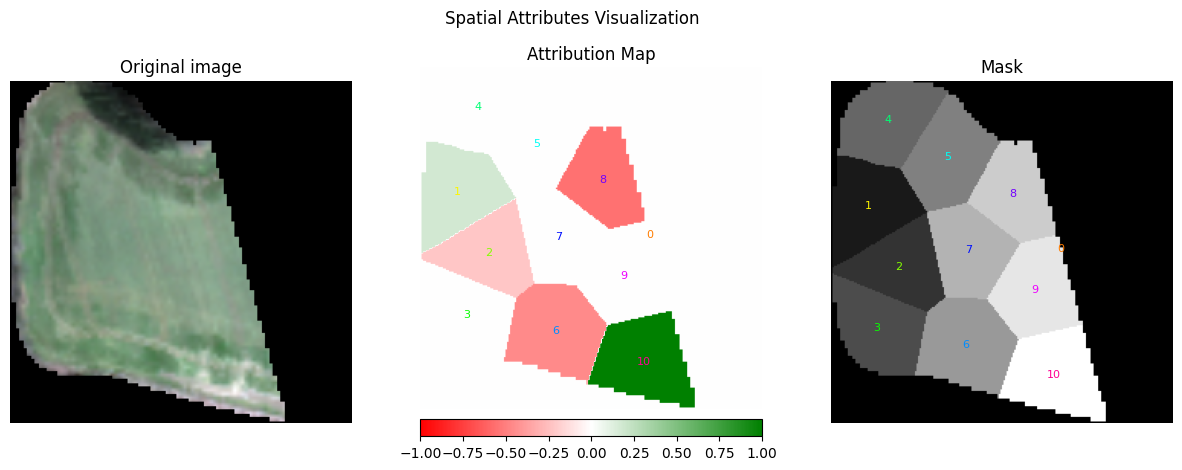

In [22]:
mt.visualize.visualize_spatial_attributes(spatial_attributes)
plt.show()

The plot presents three components (from the left)

1. On the left, the original image provided to LIME.
2. In the middle, the attribution map for each segment.
3. On the right, the segmented mask with IDs of the segments. The number 0 represents the masked region, and because it surrounds each segment, the placement of the number is in the middle of the segment.

The colors in the attribution map have the following meanings:

- **Red**: This superpixel is negatively correlated with the input. In our case, it means that the presence of this superpixel contributed to lowering the value for the target class 1.
- **White**: This segment did not have a significant impact on the output.
- **Green**: This superpixel is positively correlated with the output. Its presence increases the value for the class `1`.

To validate how well the surrogate model was trained, we also provide the `score` attribute, which indicates the `R2` metric (coefficient of determination) that measures how well the surrogate model was trained.

In [23]:
spatial_attributes.score

0.9498702883720398

High R2 score for the surrogate model hints that the attributions are sensible. In case the R2 score were very low, it could mean that the surrogate linear model can't tell which regions are more important for the explainable model preditions.

Let's analyze the attribution maps for class `0` representing phosphorus estimation. We can simply modify the `target` parameter, utilizing the same segmentation mask, and rerun the explanation process.

In [24]:
spatial_attributes = lime.get_spatial_attributes(hsi_0, segmentation_mask_slic, target=0, n_samples=10)

R2 metric: 0.6901


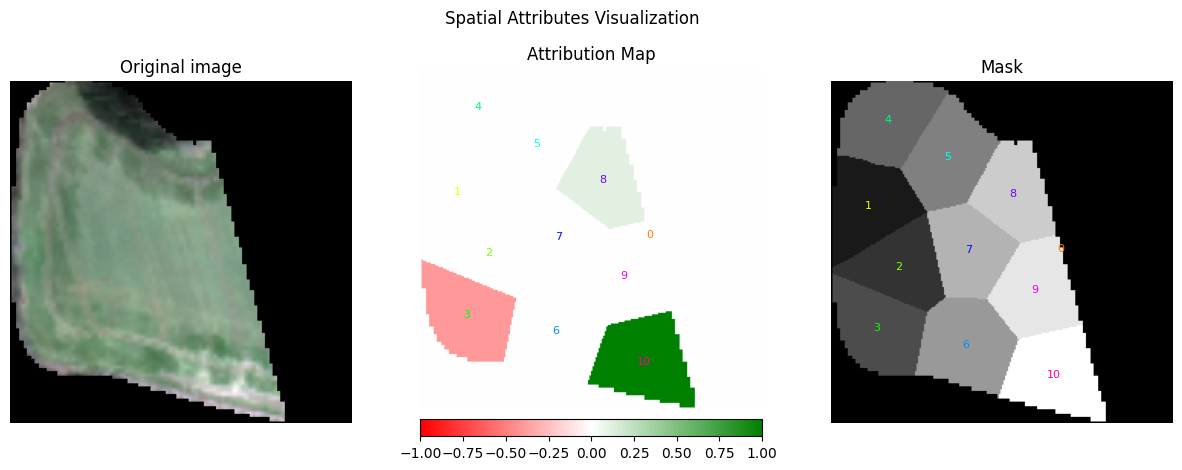

In [25]:
mt.visualize.visualize_spatial_attributes(spatial_attributes)
print(f"R2 metric: {spatial_attributes.score:.4f}")
plt.show()

In our case, the green regions may correspond to areas with a higher concentration of the parameter being tested - here phosporus. 

#### Different segmentation masks

The most semantically meaningful segmentation mask is the one created by slic method. It contains superpixels that are created based on the image structure, which choice is very similiar to the regions that a human would choose

However, `meteors` also supports creating the patch segmentation mask, but we are planning to increase support for different methods very soon.

##### Patch segmentation

Patch segmentation mask tests the importance of regions shaped as rectangles. It is designed to work well with the ViT architecure, but it gives less semantic meaning.

Let's check the `patch` segmentation mask and see how it affects the attribution maps.

In [26]:
spatial_attributes = lime.get_spatial_attributes(hsi_0, segmentation_mask_patch, target=1, n_samples=10)

R2 metric: 0.8699


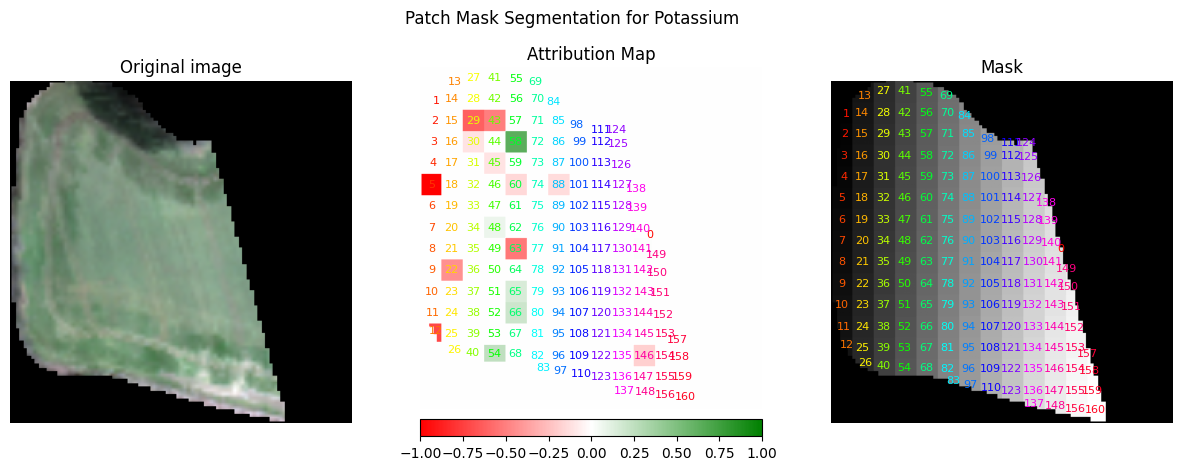

In [27]:
fig, ax = mt.visualize.visualize_spatial_attributes(spatial_attributes)
print(f"R2 metric: {spatial_attributes.score:.4f}")
fig.suptitle("Patch Mask Segmentation for Potassium")
plt.show()

As we can see the Lime explainer focused on different regions of the image, which are not consistent with the previous results. Let's try using a larger number of perturbed samples. In this way, the linear model will be trained on much more perturbed versions of the original image and will be able to mimic the predictions of the explained model better.

In [28]:
spatial_attributes = lime.get_spatial_attributes(
    hsi_0, segmentation_mask_patch, target=1, n_samples=100, perturbations_per_eval=10
)

R2 metric: 0.5538


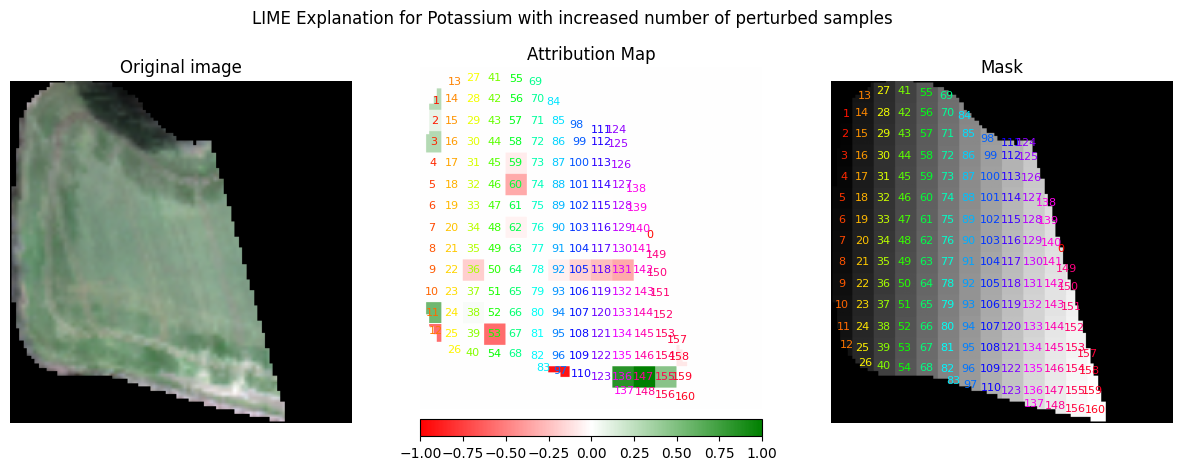

In [29]:
fig, ax = mt.visualize.visualize_spatial_attributes(spatial_attributes)
print(f"R2 metric: {spatial_attributes.score:.4f}")
fig.suptitle("LIME Explanation for Potassium with increased number of perturbed samples")
plt.show()

The explainer focuses again on the part of the image in the lower right corner and marks it as positively correlated with the output. It may suggests that the model indeed finds something interesting in this important region.

#### Custom segmentation mask

Additionally, an user might want to create their own segmentation mask, or modify the one created by the package.

Therefore, we can inspect this lower right region more thoroughly by creating a more specific segmentation mask based on the slic one.

In [30]:
thorough_segmentation_mask_slic = segmentation_mask_slic.clone()
thorough_segmentation_mask_slic[(thorough_segmentation_mask_slic != 10) & (thorough_segmentation_mask_slic != 0)] = 1

spatial_attributes = lime.get_spatial_attributes(
    hsi_0, thorough_segmentation_mask_slic, target=1, n_samples=100, perturbations_per_eval=10
)

R2 metric: 0.9755


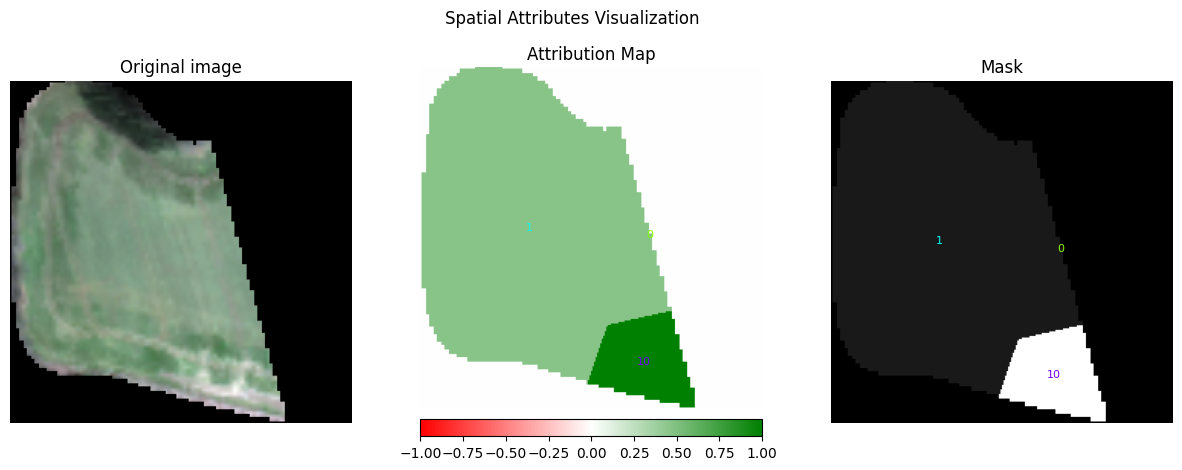

In [31]:
mt.visualize.visualize_spatial_attributes(spatial_attributes)
print(f"R2 metric: {spatial_attributes.score:.4f}")

it is visible, that this superpixel covers area that seems to be the most important region for the model. Why? This is another problem to be explained.

##### Mask importance
Using an another custom segmentation mask, we can inspect, if binary mask covers regions that should not be relevant for the model. Now we will use the binary mask used for covering irrelevant regions as a segmentation mask to verify our hypothesis.

Firstly, let's create a another HSI object, this time a plain image without any covering binary mask

In [32]:
image_without_mask = not_masked_image_torch.clone()
hsi_without_mask = mt.HSI(
    image=image_without_mask,
    wavelengths=wavelengths,
    orientation="CWH",
    device=device,
)

Now, this image with the segmentation mask that consists of only two classes, we may explore, how each region is important for the model. To do so, we repeat this process for the potassium class.

In [33]:
segmentation_mask_from_binary = binary_mask + 1
spatial_attributes = lime.get_spatial_attributes(
    hsi_without_mask, segmentation_mask_from_binary, target=1, n_samples=10
)

R2 metric: 0.4493


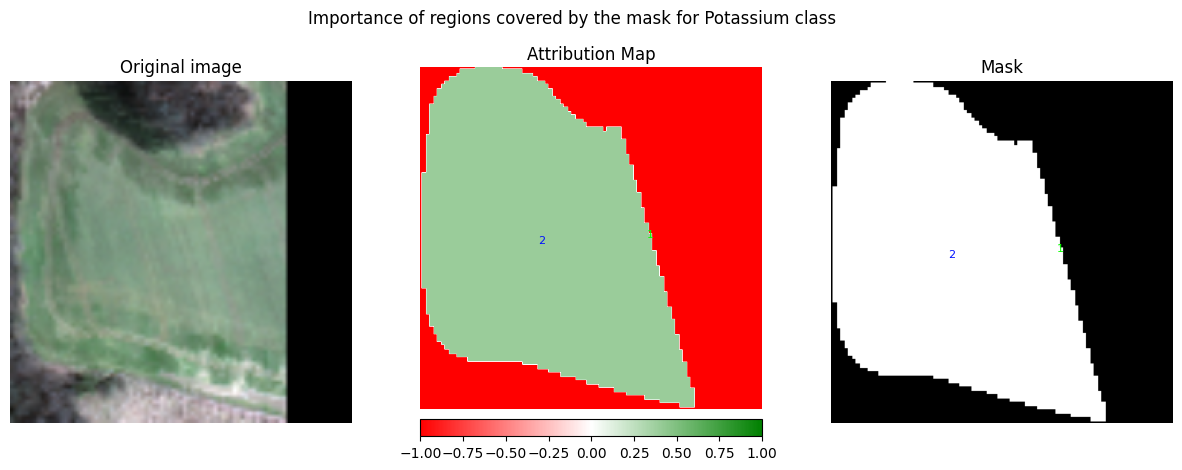

In [34]:
fig, ax = mt.visualize.visualize_spatial_attributes(spatial_attributes)
fig.suptitle("Importance of regions covered by the mask for Potassium class")
print(f"R2 metric: {spatial_attributes.score:.4f}")

as we can see, the model correctly has learned that the relevant information is not covered with the mask. The region that was covered by default using the mask is strongly negatively correlated with the output, which may suggest that indeed, mask covers some regions, causing the model to output lower values for the estimated soil parameter

### 4.2. Spectral Analysis

The spectral analysis is similar to the spatial one, but instead of analyzing the spatial dimension of the hyperspectral images, we analyze the spectral dimension - the image bands. In the process we group the specific channels of the image into superbands (groups of bands) and investigate importances of such groups. The spectral or band mask is a similar torch tensor or numpy ndarray as the segmentation mask, but instead of grouping regions it groups image channels. In the similar manner it is repeated along the width and height dimensions of the image.


Since this kind of spectral analysis has sense only in hyperspectral imaginery, we paid special attention to this novel feature. As in the case of segmentation mask, user has several options how to create the band mask, to ensure that they had no difficulty using the analysis package and could rather focus on explaining the model. In the current package version user can:

- provide the spectral indices or indexes of the commmonly recognized bands
- specify exactly which wavelengths should compose the band mask
- specify which wavelength indices corresponding to the wavelength list from the explained HSI object should be used

All these band masks can be obtained using one simple method `get_band_mask`, which detailed documentation may also be found in the [reference](https://xai4space.github.io/meteors/latest/reference/#src.meteors.attr.lime.Lime.get_band_mask). Now we will go through these different methods of creating the band mask and create some attributions.

#### Band and indices names
This, definetely the fastest for the user, method provides a quick way to explore importance of some well known superbands. To create the band mask using this approach, all we need to do is to pass a list or a dictionary of the band names:

In [35]:
band_mask, band_names = lime.get_band_mask(hsi_0, ["R", "G", "B"])

2024-11-25 15:14:54.637 | WARNING  | meteors.attr.lime:_check_overlapping_segments:827 - Segments G and B are overlapping, overlapping wavelengths will be assigned to only one


this method outpus a tuple of two variables:

- `band_mask` - a created band mask
- `band_names` - a dictionary containing mapping from provided labels and segment indices

**Note** The warning indicates that certain band groups have overlapping wavelengths. In such cases, each wavelength will be uniquely assigned to only **one** band group, avoiding duplicate assignments.

In this case we created a band mask that contains 4 superpixels - one for each of the base colours and another one including all the background.

In [36]:
band_names

{'R': 1, 'G': 2, 'B': 3}

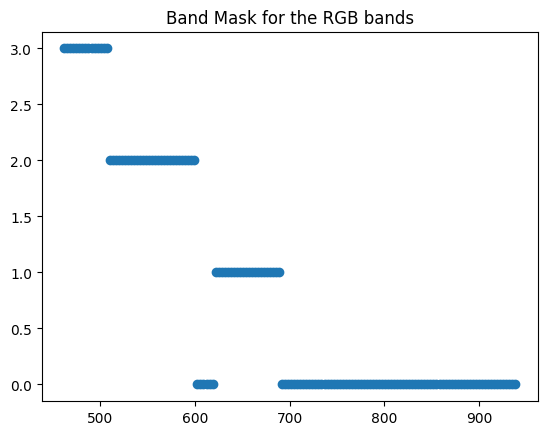

In [37]:
plt.scatter(wavelengths, band_mask.squeeze(1).squeeze(1))

plt.title("Band Mask for the RGB bands")

plt.show()

The plot presents how bands are grouped. The bands with the value 0 creates the additional band group `not_included` which also will be used in the analysis. You may also notice that the overlapping wavelengths are only assigned to one group.

Now, we can analyze the hyperspectral image based on the spectral dimension. We will use the same LIME model as in the spatial analysis (initialize with the same parameters), but we will provide the band mask instead of the segmentation mask and also band names.

In [38]:
lime = mt.attr.Lime(
    explainable_model=mt.models.ExplainableModel(model, "regression"),
    interpretable_model=mt.models.SkLearnLasso(alpha=0.001),
)

In [39]:
spectral_attributes = lime.get_spectral_attributes(
    hsi_0,
    band_mask=band_mask,
    target=1,
    band_names=band_names,
    n_samples=10,
)

The spectral attributions are similar to spatial attributes consisting of `hsi`, `mask`, `attributes` and `score` of the linear model.

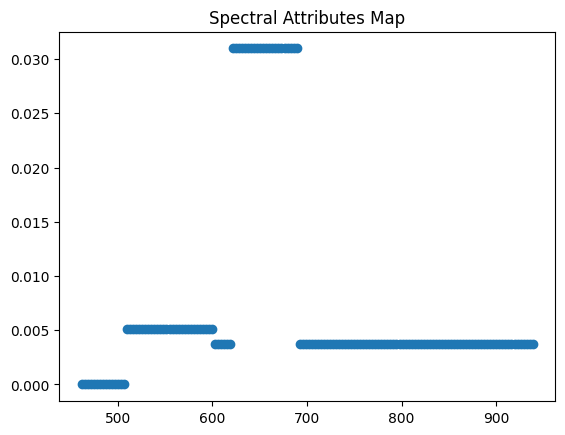

In [40]:
assert len(wavelengths) == spectral_attributes.flattened_attributes.shape[0]
plt.scatter(wavelengths, spectral_attributes.flattened_attributes)
plt.title("Spectral Attributes Map")
plt.show()

But again as with spatial analysis it is much easier to visualize the results using the provided meteors visualization functions.

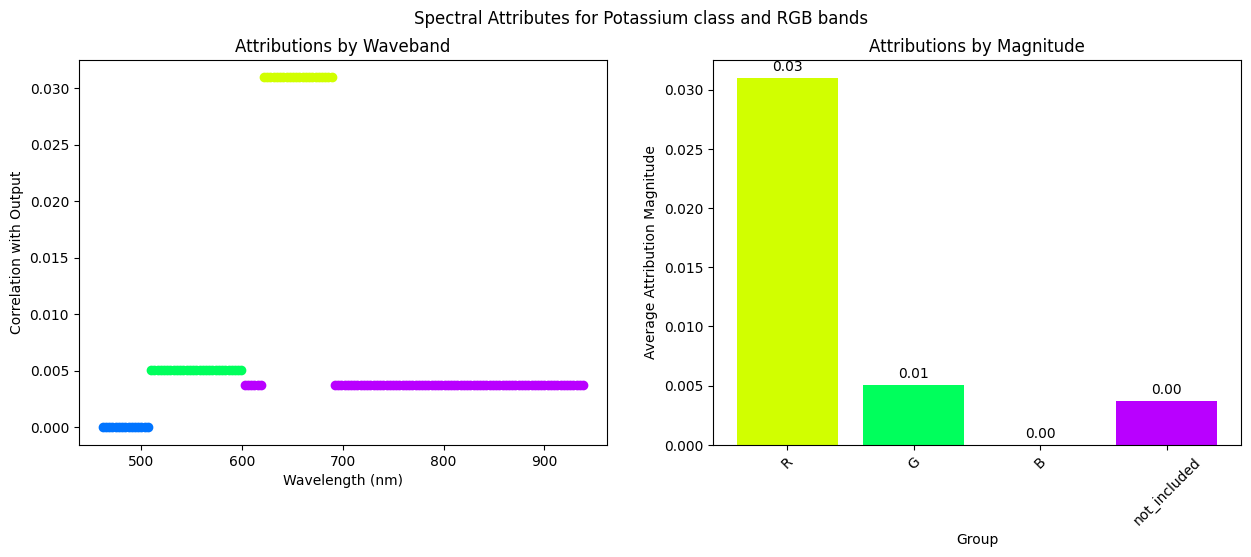

In [41]:
fig, ax = mt.visualize.visualize_spectral_attributes(spectral_attributes, show_not_included=True)
fig.suptitle("Spectral Attributes for Potassium class and RGB bands")
plt.show()

The plot this time consists of two parts. On the left, we have the attribution value per band for the hyperspectral image it helps to identify, which particular bands are important, whilist the right plot helps to identify the most important superbands and compare magnitudes of its importance. 

On the plot above, we may see that the red superband is much more important than the green and blue ones. How would the situation change if we compared red superband and blue and green superband together?


Fortunately, thanks to the method `get_band_mask` it is incredibely easy - we just need to specify bands that will produce the superband.


In [42]:
band_mask, band_names = lime.get_band_mask(hsi_0, ["R", ["G", "B"]])

and as before we can create the attributions for the selected superbands using LIME explainer.

In [43]:
spectral_attributes = lime.get_spectral_attributes(
    hsi_0,
    band_mask=band_mask,
    target=1,
    band_names=band_names,
    n_samples=10,
)

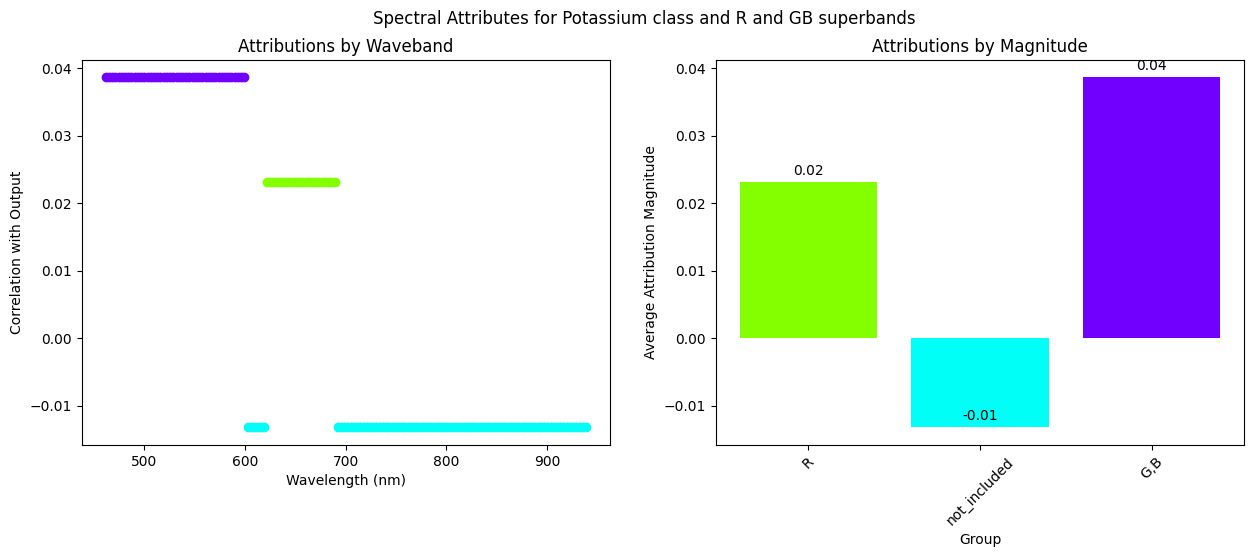

In [44]:
fig, ax = mt.visualize.visualize_spectral_attributes(spectral_attributes, show_not_included=True)
fig.suptitle("Spectral Attributes for Potassium class and R and GB superbands")
plt.show()

it looks that, indeed, green and blue superbands combined are more important than the red one.

To validate the model, we again can use the `score` attribute, which indicates the `R2` metric of how well-trained the surrogate model was.

In [45]:
spectral_attributes.score

0.65287184715271

All the band names are sourced from the [Awesome Spectral Indices](https://github.com/awesome-spectral-indices/awesome-spectral-indices?tab=readme-ov-file#expressions) repository and handled using the `spyndex` library. Therefore, we can explore all the bands or try out some more exotic combinations using the predefined band indices [here](https://github.com/awesome-spectral-indices/awesome-spectral-indices?tab=readme-ov-file#spectral-indices-by-application-domain) 

We will use now one of the indices taken from the library, a Bare Soil Index, which is a combination of couple of base bands. It can be defined as
$$
BI = \frac{(S1 + R) - (N + B)}{(S1 + R) + (N + B)}
$$

where S1 corresponds to SWIR 1 band, R and B to red and blue respectively and N to NIR band. It is used, as the name suggests, to detect bare soil in the hyperspectral imaginery and possibly can be used as well to detect soil parameters.

In [46]:
band_mask, band_names = lime.get_band_mask(hsi_0, ["G", "BI"])

2024-11-25 15:15:13.044 | WARNING  | meteors.attr.lime:_check_overlapping_segments:827 - Segments G and BI are overlapping, overlapping wavelengths will be assigned to only one


now, using the same methods as before, we can attribute the new superbands using the LIME explainer and visualize the output

In [47]:
band_names

{'G': 1, 'BI': 2}

In [48]:
spectral_attributes = lime.get_spectral_attributes(
    hsi_0,
    band_mask=band_mask,
    target=1,
    band_names=band_names,
    n_samples=10,
)

R2 metric: 0.9540


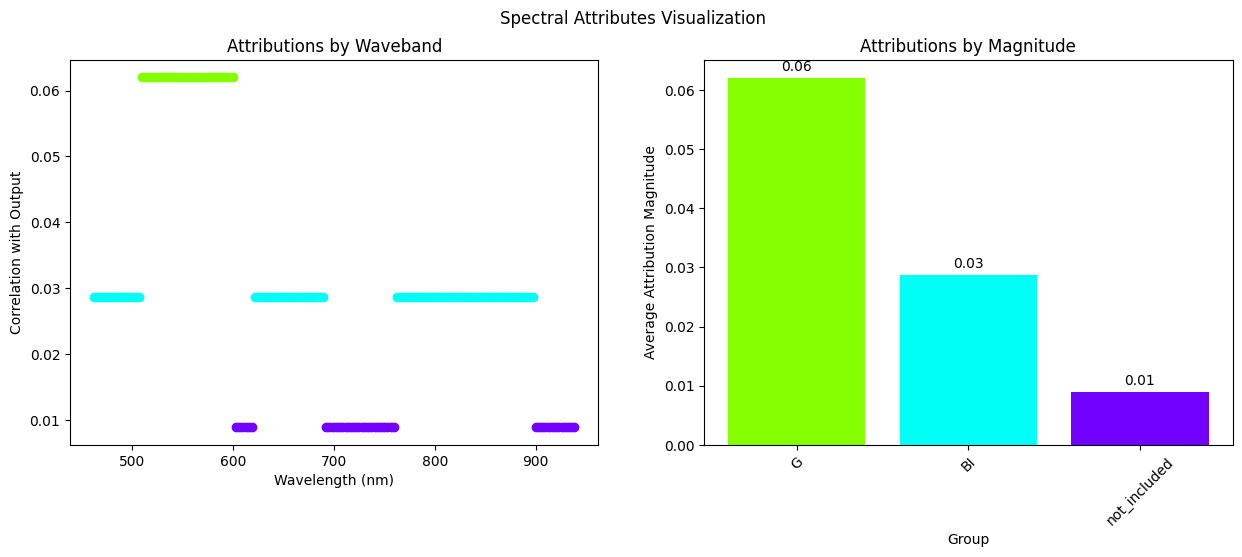

In [49]:
mt.visualize.visualize_spectral_attributes(spectral_attributes, show_not_included=True)
print(f"R2 metric: {spectral_attributes.score:.4f}")
plt.show()

it seems that the superband BI is actually irrelevant for the model in this specific case. It looks that the model does not base its predictions for the current image on this specific bands

In this way, we may investigate if the model uses the bands that were commonly used for the similar tasks in the literature, which could help us debbuging the model! 
Now we will use some bands, that should really be important to the model.

#### Wavelengths ranges
In some cases, we do not want to use any well known band combinations. In our team, we had access to knowledge of domain experts who gave us the exact wavelength values that are used to detect potassium, phosphorus, magnessium and pH in the soil. Now we can utilize this knowledge and create our own superbands. 

Now we will try out the values for the potassium. Unfortunately, not all the wavelengths provided are exactly mentioned in our wavelengths list, thus we need to find the closest corresponding indices to the values given by the experts.

In [50]:
potassium_superband_indices = [0, 1, 4, 10, 43, 46, 47]
potassium_superband_wavelengths = [wavelengths[i] for i in potassium_superband_indices]

In [51]:
potassium_superband_wavelengths

[462.08, 465.27, 474.86, 494.04, 599.53, 609.12, 612.32]

In [52]:
band_dict = {"potassium": potassium_superband_indices, "another_superpixel": [i for i in range(20, 30)]}
band_dict

{'potassium': [0, 1, 4, 10, 43, 46, 47],
 'another_superpixel': [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]}

In [53]:
band_mask, band_names = lime.get_band_mask(hsi_0, band_indices=band_dict)

In [54]:
band_names

{'potassium': 1, 'another_superpixel': 2}

In [55]:
spectral_attributes = lime.get_spectral_attributes(
    hsi_0,
    band_mask=band_mask,
    target=1,
    band_names=band_names,
    n_samples=100,
)

R2 metric: 0.4785


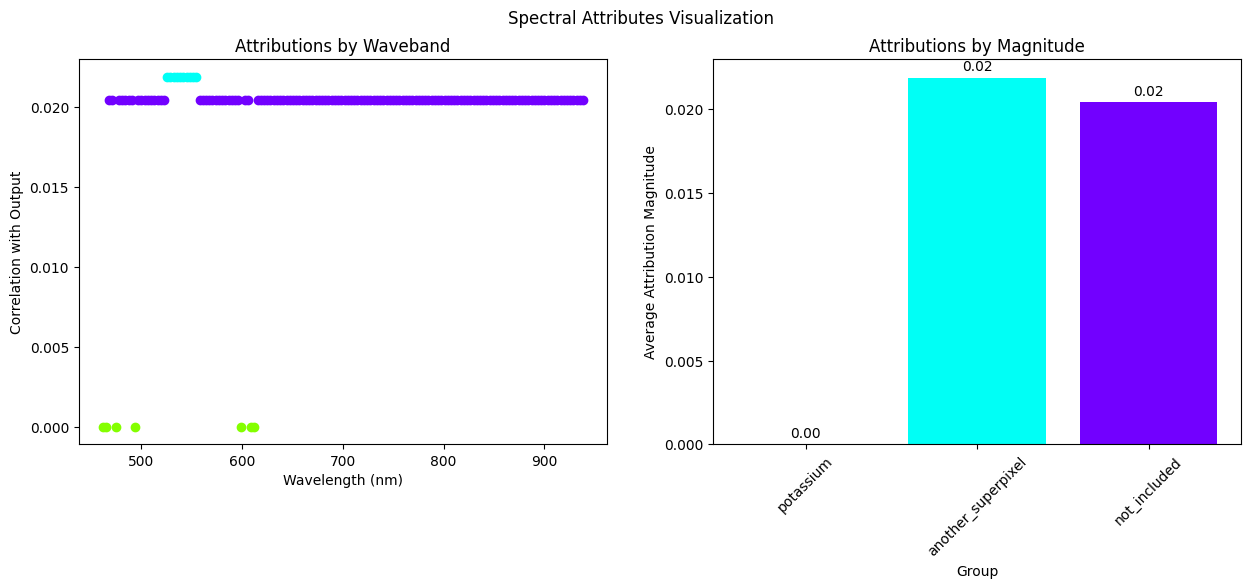

In [56]:
mt.visualize.visualize_spectral_attributes(spectral_attributes, show_not_included=True)
print(f"R2 metric: {spectral_attributes.score:.4f}")
plt.show()

As it turns out, in this case, the bands given us by the experts are not necessarily important for the model. We need to remember, that this analysis is performed for solely one image. Perhaps, this is just one outlier and in different cases model might actually use the specified bands. For such cases, we can utilize the *global explanations* which are attributions aggregeated for multiple input images. 

### Global attributions

An interesting capability unique to spectral analysis is the ability to aggregate results across multiple samples, allowing us to transition from local interpretation to global interpretation. This is usually not possible for spatial analysis, as the images differ significantly when it comes to the covered land. Aggregating spatial information is challenging due to the lack of straightforward method for determining which parts of different images are similar, as the covered land can vary significantly. On the contrary, spectral analysis benefits from consistent bands accross images, allowing for specification of common superbands.

To give an idea how to perform such analysis, we need a second sample of the hyperspectral image.

In [57]:
data, mask = load_single_npz_image("data/1.npz")
masked_data = data * mask
masked_data = torch.from_numpy(masked_data.astype(np.float32)).permute(2, 0, 1)
eval_tr = get_eval_transform(224)

image_torch_1 = eval_tr(masked_data)
not_masked_image_torch_1 = eval_tr(torch.from_numpy(data.astype(np.float32)).permute(2, 0, 1))

Text(0.5, 1.0, 'Another sample image from the HYPERVIEW dataset')

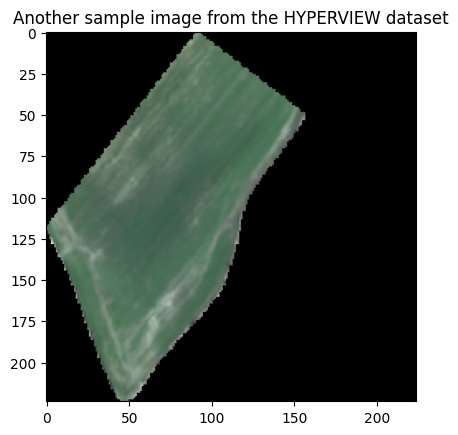

In [58]:
binary_mask_1 = (image_torch_1 > 0.0).int()

hsi_1 = mt.HSI(
    image=not_masked_image_torch_1, wavelengths=wavelengths, orientation="CWH", binary_mask=binary_mask_1, device=device
)

ax = mt.visualize.visualize_hsi(hsi_1, use_mask=True)
ax.set_title("Another sample image from the HYPERVIEW dataset")

Now, once the image is properly loaded and preprocessed, let's get the attributions for the second sample, using the same band mask as before

In [59]:
spectral_attributes_1 = lime.get_spectral_attributes(
    hsi_1, band_mask=band_mask, target=1, band_names=band_names, n_samples=100
)

R2 metric: 0.4785


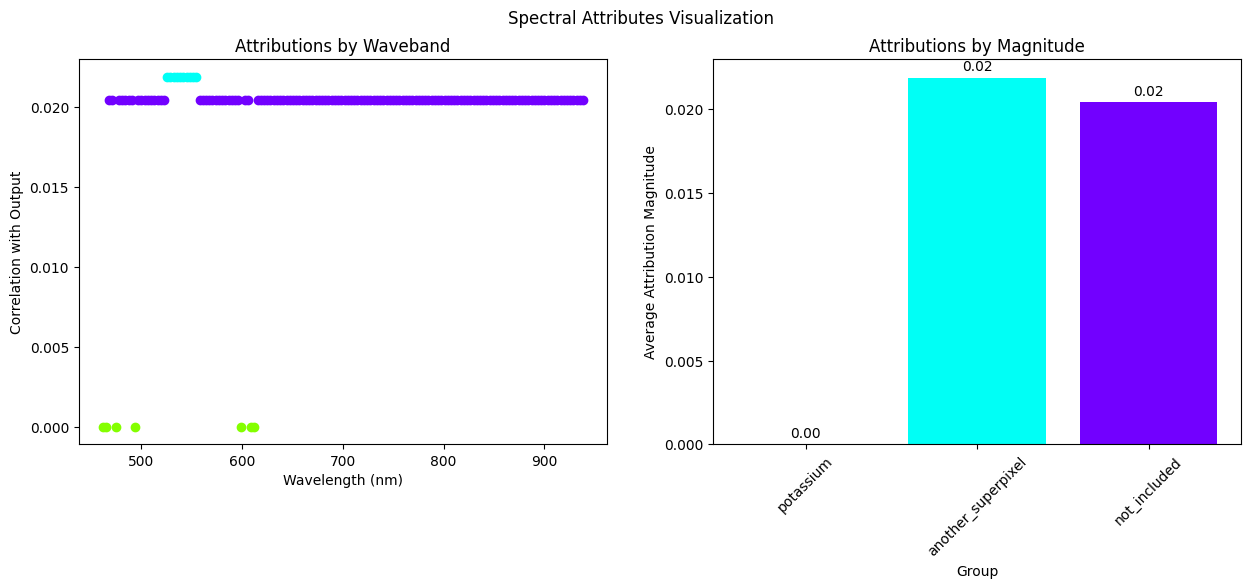

In [60]:
mt.visualize.visualize_spectral_attributes(spectral_attributes, show_not_included=True)
print(f"R2 metric: {spectral_attributes.score:.4f}")
plt.show()

To get the global interpretation we will provide the list of attributions to the meteors visualizer to create the global interpretation visualization.

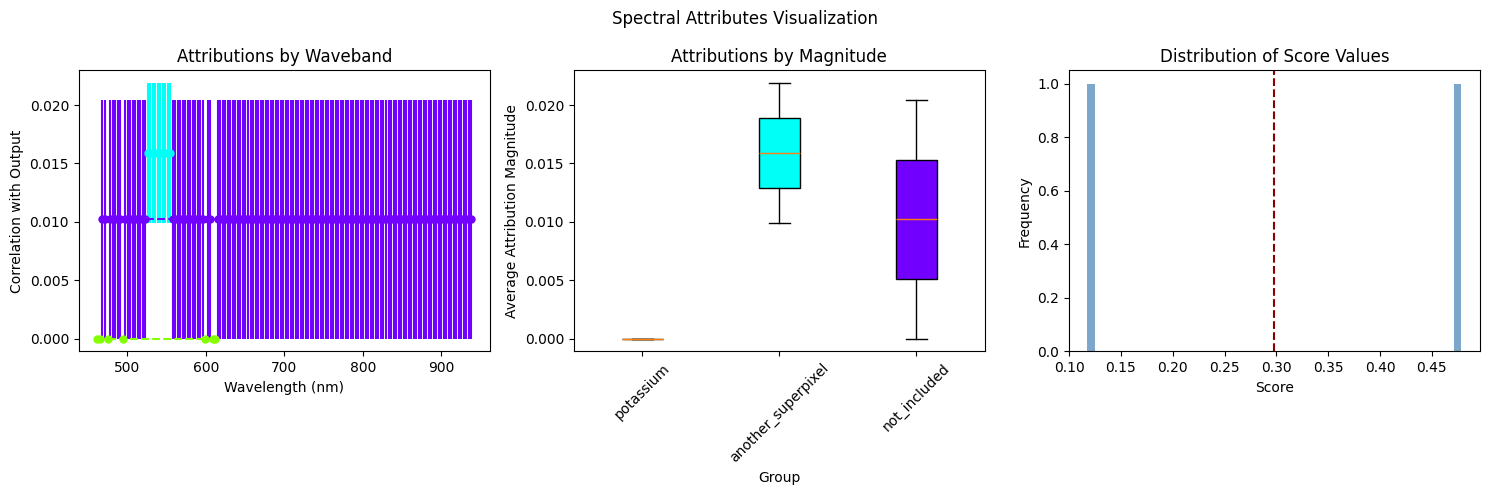

In [61]:
mt.visualize.visualize_spectral_attributes([spectral_attributes, spectral_attributes_1], show_not_included=True)
plt.tight_layout()
plt.show()

As it turns out, the model does not necessarily use the specified bands in the prediction of the potassium class. This is probably insufficient to conclude anything using only attributions from 2 images, especially because the `score` of the explanations was low, but our model suprisingly does not use the expected wavelengths.